# Import relevant libraries/modules etc

In [16]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
from matplotlib.pyplot import *
from glob import glob
import os
import datetime
import pandas as pd
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio

# Create an array with MAIAC data

- create a function which reads in the files, determines the no data values, and creates a third dim 'time'
- create a list with all of the files to be put in the 3d array
- run the function on every element of list (map)

In [17]:
def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    time_str = os.path.basename(filename)[17:-13]
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj

    return da

In [18]:
files = glob(r'D:\Annies_Dissertation\MAIAC_Test\subset\Projected\????\*_PM25.tif')

In [19]:
list_of_das = map(maiac_file_to_da, files)

In [20]:
MAIAC_PM25 = xr.concat(list_of_das, 'time')

In [ ]:
- view the dataset
- view the different 3D timestamps

In [21]:
MAIAC_PM25

<xarray.DataArray (time: 39, y: 1162, x: 1240)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  

In [22]:
MAIAC_PM25.time

<xarray.DataArray 'time' (time: 39)>
array(['2000-03-01T11:10:00.000000000', '2000-03-01T12:50:00.000000000',
       '2000-03-01T14:25:00.000000000', '2000-03-02T10:15:00.000000000',
       '2000-03-02T11:55:00.000000000', '2000-03-02T13:30:00.000000000',
       '2000-03-03T11:00:00.000000000', '2000-03-03T12:35:00.000000000',
       '2000-03-03T14:15:00.000000000', '2012-01-01T13:10:00.000000000',
       '2012-01-01T14:50:00.000000000', '2012-01-02T12:15:00.000000000',
       '2012-01-02T13:55:00.000000000', '2012-01-03T13:00:00.000000000',
       '2012-01-03T14:40:00.000000000', '2012-01-04T13:40:00.000000000',
       '2012-01-05T12:45:00.000000000', '2012-01-05T14:25:00.000000000',
       '2012-01-06T11:50:00.000000000', '2013-01-01T11:45:00.000000000',
       '2013-01-01T13:25:00.000000000', '2013-01-01T15:05:00.000000000',
       '2013-01-02T12:30:00.000000000', '2013-01-02T14:05:00.000000000',
       '2013-01-03T11:35:00.000000000', '2013-01-03T13:10:00.000000000',
       '2013-0

# Group data
- merge multiple images per day using the maximum AOT estimates

In [23]:
PM25 = MAIAC_PM25.isel(time=np.argsort(MAIAC_PM25.time))

In [24]:
PM25.time

<xarray.DataArray 'time' (time: 39)>
array(['2000-03-01T11:10:00.000000000', '2000-03-01T12:50:00.000000000',
       '2000-03-01T14:25:00.000000000', '2000-03-02T10:15:00.000000000',
       '2000-03-02T11:55:00.000000000', '2000-03-02T13:30:00.000000000',
       '2000-03-03T11:00:00.000000000', '2000-03-03T12:35:00.000000000',
       '2000-03-03T14:15:00.000000000', '2012-01-01T13:10:00.000000000',
       '2012-01-01T14:50:00.000000000', '2012-01-02T12:15:00.000000000',
       '2012-01-02T13:55:00.000000000', '2012-01-03T13:00:00.000000000',
       '2012-01-03T14:40:00.000000000', '2012-01-04T13:40:00.000000000',
       '2012-01-05T12:45:00.000000000', '2012-01-05T14:25:00.000000000',
       '2012-01-06T11:50:00.000000000', '2013-01-01T11:45:00.000000000',
       '2013-01-01T13:25:00.000000000', '2013-01-01T15:05:00.000000000',
       '2013-01-02T12:30:00.000000000', '2013-01-02T14:05:00.000000000',
       '2013-01-03T11:35:00.000000000', '2013-01-03T13:10:00.000000000',
       '2013-0

In [28]:
Daily_PM25 = PM25.resample('D', dim='time', how='median')

In [29]:
Daily_PM25.time

<xarray.DataArray 'time' (time: 5059)>
array(['2000-03-01T00:00:00.000000000', '2000-03-02T00:00:00.000000000',
       '2000-03-03T00:00:00.000000000', ...,
       '2014-01-03T00:00:00.000000000', '2014-01-04T00:00:00.000000000',
       '2014-01-05T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-03-01 2000-03-02 2000-03-03 ...

# Analysis
## overall average of every pixel

In [30]:
overall_mean = PM25.mean(dim='time', keep_attrs=True)

In [31]:
overall_mean.attrs

OrderedDict([('affine',
              (-947639.6305106478,
               1256.5430440955893,
               0.0,
               1429277.8120091767,
               0.0,
               -1256.5430440955893)),
             ('crs', '+init=epsg:27700')])

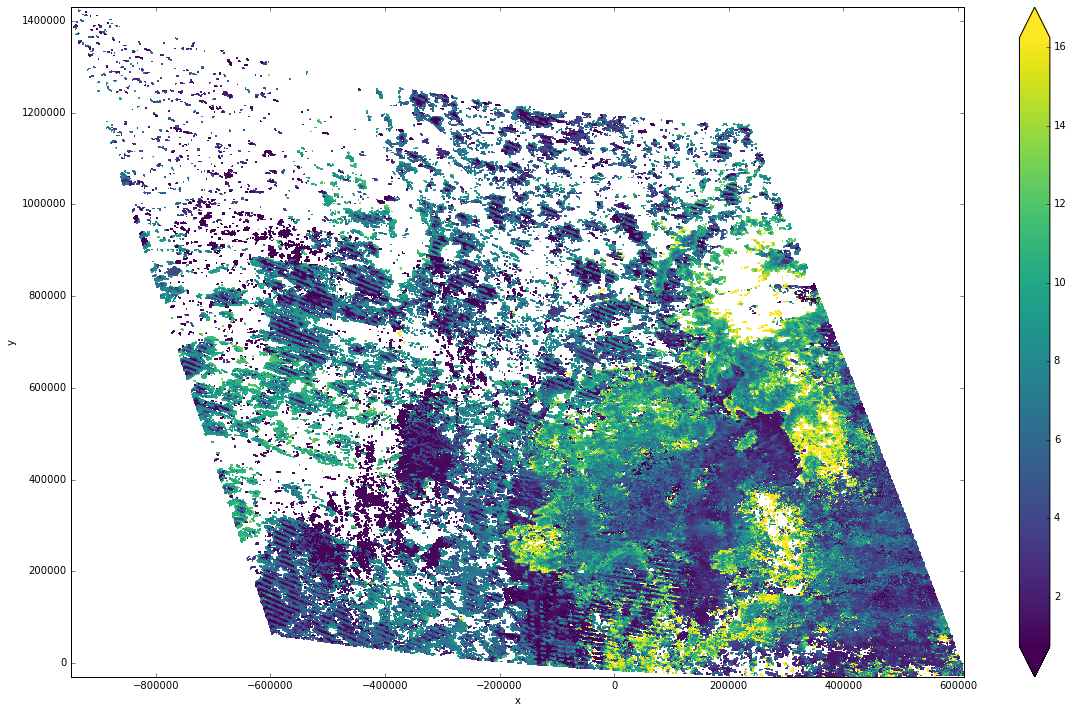

In [32]:
figure(figsize=(20, 12))
overall_mean.plot(robust=True)

In [13]:
xarray_to_rasterio(overall_mean, r'D:\Annies_Dissertation\MAIAC_Test\Projected\2014\overall_mean_out.tif')

## Averages
### Monthly

In [53]:
monthly = reordered_MAIAC_AOT.groupby('time.month').max(dim='time')

In [54]:
monthly.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * month    (month) int64 1

In [ ]:
figure(figsize=(20, 12))
monthly.plot(col='month', robust=True)

### Seasonal

In [56]:
seasonal = r.groupby('time.season').max(dim='time')

In [57]:
seasonal.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * season   (season) object 'DJF'

In [ ]:
figure(figsize=(20, 12))
season.plot(col='season', robust=True)

### Yearly

In [ ]:
yearly = r.groupby('date.year').max(dim='date')

In [ ]:
yearly.coords

In [ ]:
figure(figsize=(20, 12))
yearly.plot(col='year', robust=True)

# Count of values that aren't missing

In [16]:
observations = r.count(dim='date')

(array([  1.11791600e+06,   0.00000000e+00,   2.16945000e+05,
          0.00000000e+00,   8.35610000e+04,   0.00000000e+00,
          1.94620000e+04,   0.00000000e+00,   2.91600000e+03,
          8.00000000e+01]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

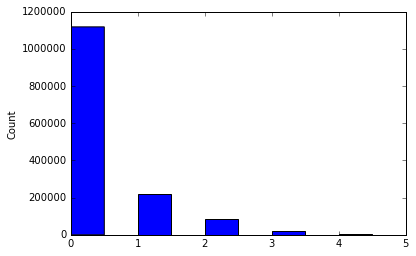

In [17]:
observations.plot.hist()